# [ 목표 : 주택가격 예측하기 ]
## - 조건에 맞는 주택수준 찾기 -

## Step 0. 데이터 불러오기 ##

In [1]:
# 필요한 Library 들을 불러온다.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import scale, robust_scale, minmax_scale
import statsmodels.formula.api as smf


from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import scale

### Boston Google Map
<img src = "imgFolder/boaston.png">

                            - 보스턴은 큰 내륙과 여러개의 작은 섬들로 이루어져 있다.

![](imgFolder/boaston.img)

## 데이터 변수 분석

##### 1. 주택가격(MEDV)
    조사기간동안 주택변동가격의 중앙값(단위: 1000달러).
##### 2. 범죄율(CRIM)
    마을의 1인당 범죄율
    한국의 형법범죄율 = (형법범죄 발생건수 ÷ 인구) × 100,000.
##### 3. 주거지비율(ZN)
    집 크기 25000sq.ft 이상 구획된 주택지 비율.(단위: %)
    -> 25000sq.ft는 한국 기준 702.57924 평.    
##### 4. 산화질소(NOX)농도
    가설: 는 인체 면역력 향상에 도움을 준다. VS 유독가스이다. 
    가열시 폭발, 흡입시 유독으로 인체 외부에서는 안좋지만, 인체 내부에서 생성되는 산화질소(체내 산화질소)는 유익하다. 
    혈관 내 산화질소 생성이 부족하면 협심증·심근경색·심장마비·뇌졸중·당뇨병 등에 걸리기 쉽다.
    -> 이 데이터에서는 사람의 체내 산화질소에 대한 데이터가 아니므로, 공기 중 산화질소 농도로 파악된다.
##### 5. 비소매업 비율(INDUS)
    마을 당 비 소매 상업지역 비율(단위: %)
##### 6. 강 조망 여부(CHAS)
    Charles river 의 조망권 유무
##### 7. 주거당 평균 객실 수(RM)
    주택 당 객실의 평균 개수
##### 8. 노후 건물 비율(AGE)
    1940년 이전에 건설 된 건물의 비율(단위: %).
##### 9. 중심지(노동센터) 접근 거리(DIS)
    보스턴 고용 센터 5 곳까지의 가중거리 합. 
##### 10. 고속도로 접근 편이성 지수(RAD)
    방사형 고속도로 접근 지수.
    의문 : 편이성 지수가 좋다! 라는 것은 지수가 작을수록인가 클수록인가?
##### 11. 재산세율(TAX)
    10000 달러 당 세금.
    -> 10000으로 나눠 비율로 변환할 필요성.  
##### 12. 학생당 교사 비율(PTRATIO)
    마을 별 학생 대 교사 수 비율(단위: 비율)
##### 13. 흑인 인구 비율(B)
    마을의 아프리카계 미국인 비율( 1000 * (Bk-0.63)**2 )
##### 14. 저소득층 비율(LSTAT)
    소득 하위 계층의 비율(단위: %)    


# 가설.
1. 범죄율이 높으면 주택 가격은 낮을 것이다.
2. 저소득층 비율이 높으면 주택 가격은 낮을 것이다. -> 소득하위계층이 많이 살려면 주택가격이 낮아야 할 것이다.
3. 흑인 인구 비율이 높으면 주택 가격은 낮을 것이다. -> 흑인과 백인의 소득격차가 있을 것이라는 생각.
4. 노후건물비율이 높으면 주택 가격은 낮을 것이다. -> 건물 안전성과 관련하여 붕괴 위험성이 높기 때문.(지진 등 재해에 취약)
5. 산화질소농도가 높으면 주택 가격은 낮을 것이다. -> 공기 질이 안좋으면 건강에 문제가 생기기 때문에, 기피하게 된다.


1. 재산세율이 높으면 주택 가격은 높을 것이다. -> 부자동네라는 증거라고 생각된다.
2. 조강권이라면 주택 가격은 높을 것이다. -> 좋은 환경일수록 주택가격은 높을 것이다.
3. 방사형 고속도로와 가까우면 주택 가격이 높을 것이다. -> 미국은 땅이 커서 주로 차로 이동하기 때문
4. 주거 당 평균 객실 수가 높으면 주택 가격이 높을 것이다. -> 방이 많다는 것은 집이 크다는 것(부지가 넓다), 큰 집은 가격도 높다.
5. 학생당 교사비율이 높으면 주택 가격이 높을 것이다. -> 이 지표는 교육수준을 보여주기 때문

1. 주거지 비율이 높으면 비소매업 비율도 높을 것이다.

In [2]:
# 데이터 파일을 불러온다.
df_house = pd.read_csv("실습파일/BOSTON_HOUSING.csv", engine = 'python')
df_house.head()

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,24.000000,0.00632,18.0,2.31,0,0.538,6.575,65.199997,4.0900,1,296,15.300000,396.899994,4.98
1,21.600000,0.02731,0.0,7.07,0,0.469,6.421,78.900002,4.9671,2,242,17.799999,396.899994,9.14
2,34.700001,0.02729,0.0,7.07,0,0.469,7.185,61.099998,4.9671,2,242,17.799999,392.829987,4.03
3,33.400002,0.03237,0.0,2.18,0,0.458,6.998,45.799999,6.0622,3,222,18.700001,394.630005,2.94
4,36.200001,0.06905,0.0,2.18,0,0.458,7.147,54.200001,6.0622,3,222,18.700001,396.899994,5.33


In [3]:
df_house.isnull()

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [4]:
# TAX 를 %단위로 변수 조정
df_house.TAX = (df_house[['TAX']]/10000 )* 100
df_house.head()

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,24.000000,0.00632,18.0,2.31,0,0.538,6.575,65.199997,4.0900,1,2.96,15.300000,396.899994,4.98
1,21.600000,0.02731,0.0,7.07,0,0.469,6.421,78.900002,4.9671,2,2.42,17.799999,396.899994,9.14
2,34.700001,0.02729,0.0,7.07,0,0.469,7.185,61.099998,4.9671,2,2.42,17.799999,392.829987,4.03
3,33.400002,0.03237,0.0,2.18,0,0.458,6.998,45.799999,6.0622,3,2.22,18.700001,394.630005,2.94
4,36.200001,0.06905,0.0,2.18,0,0.458,7.147,54.200001,6.0622,3,2.22,18.700001,396.899994,5.33


## Step 1. 그래프를 활용한 탐색적 분석

In [5]:
# 데이터 크기 확인.
df_house_y = df_house["MEDV"]
df_house_x = df_house.drop("MEDV", axis = 1, inplace = False)

print("목표변수 데이터 크기: {}".format(df_house_y.shape))
print("설명변수 데이터 크기: {}".format(df_house_x.shape))

목표변수 데이터 크기: (506,)
설명변수 데이터 크기: (506, 13)


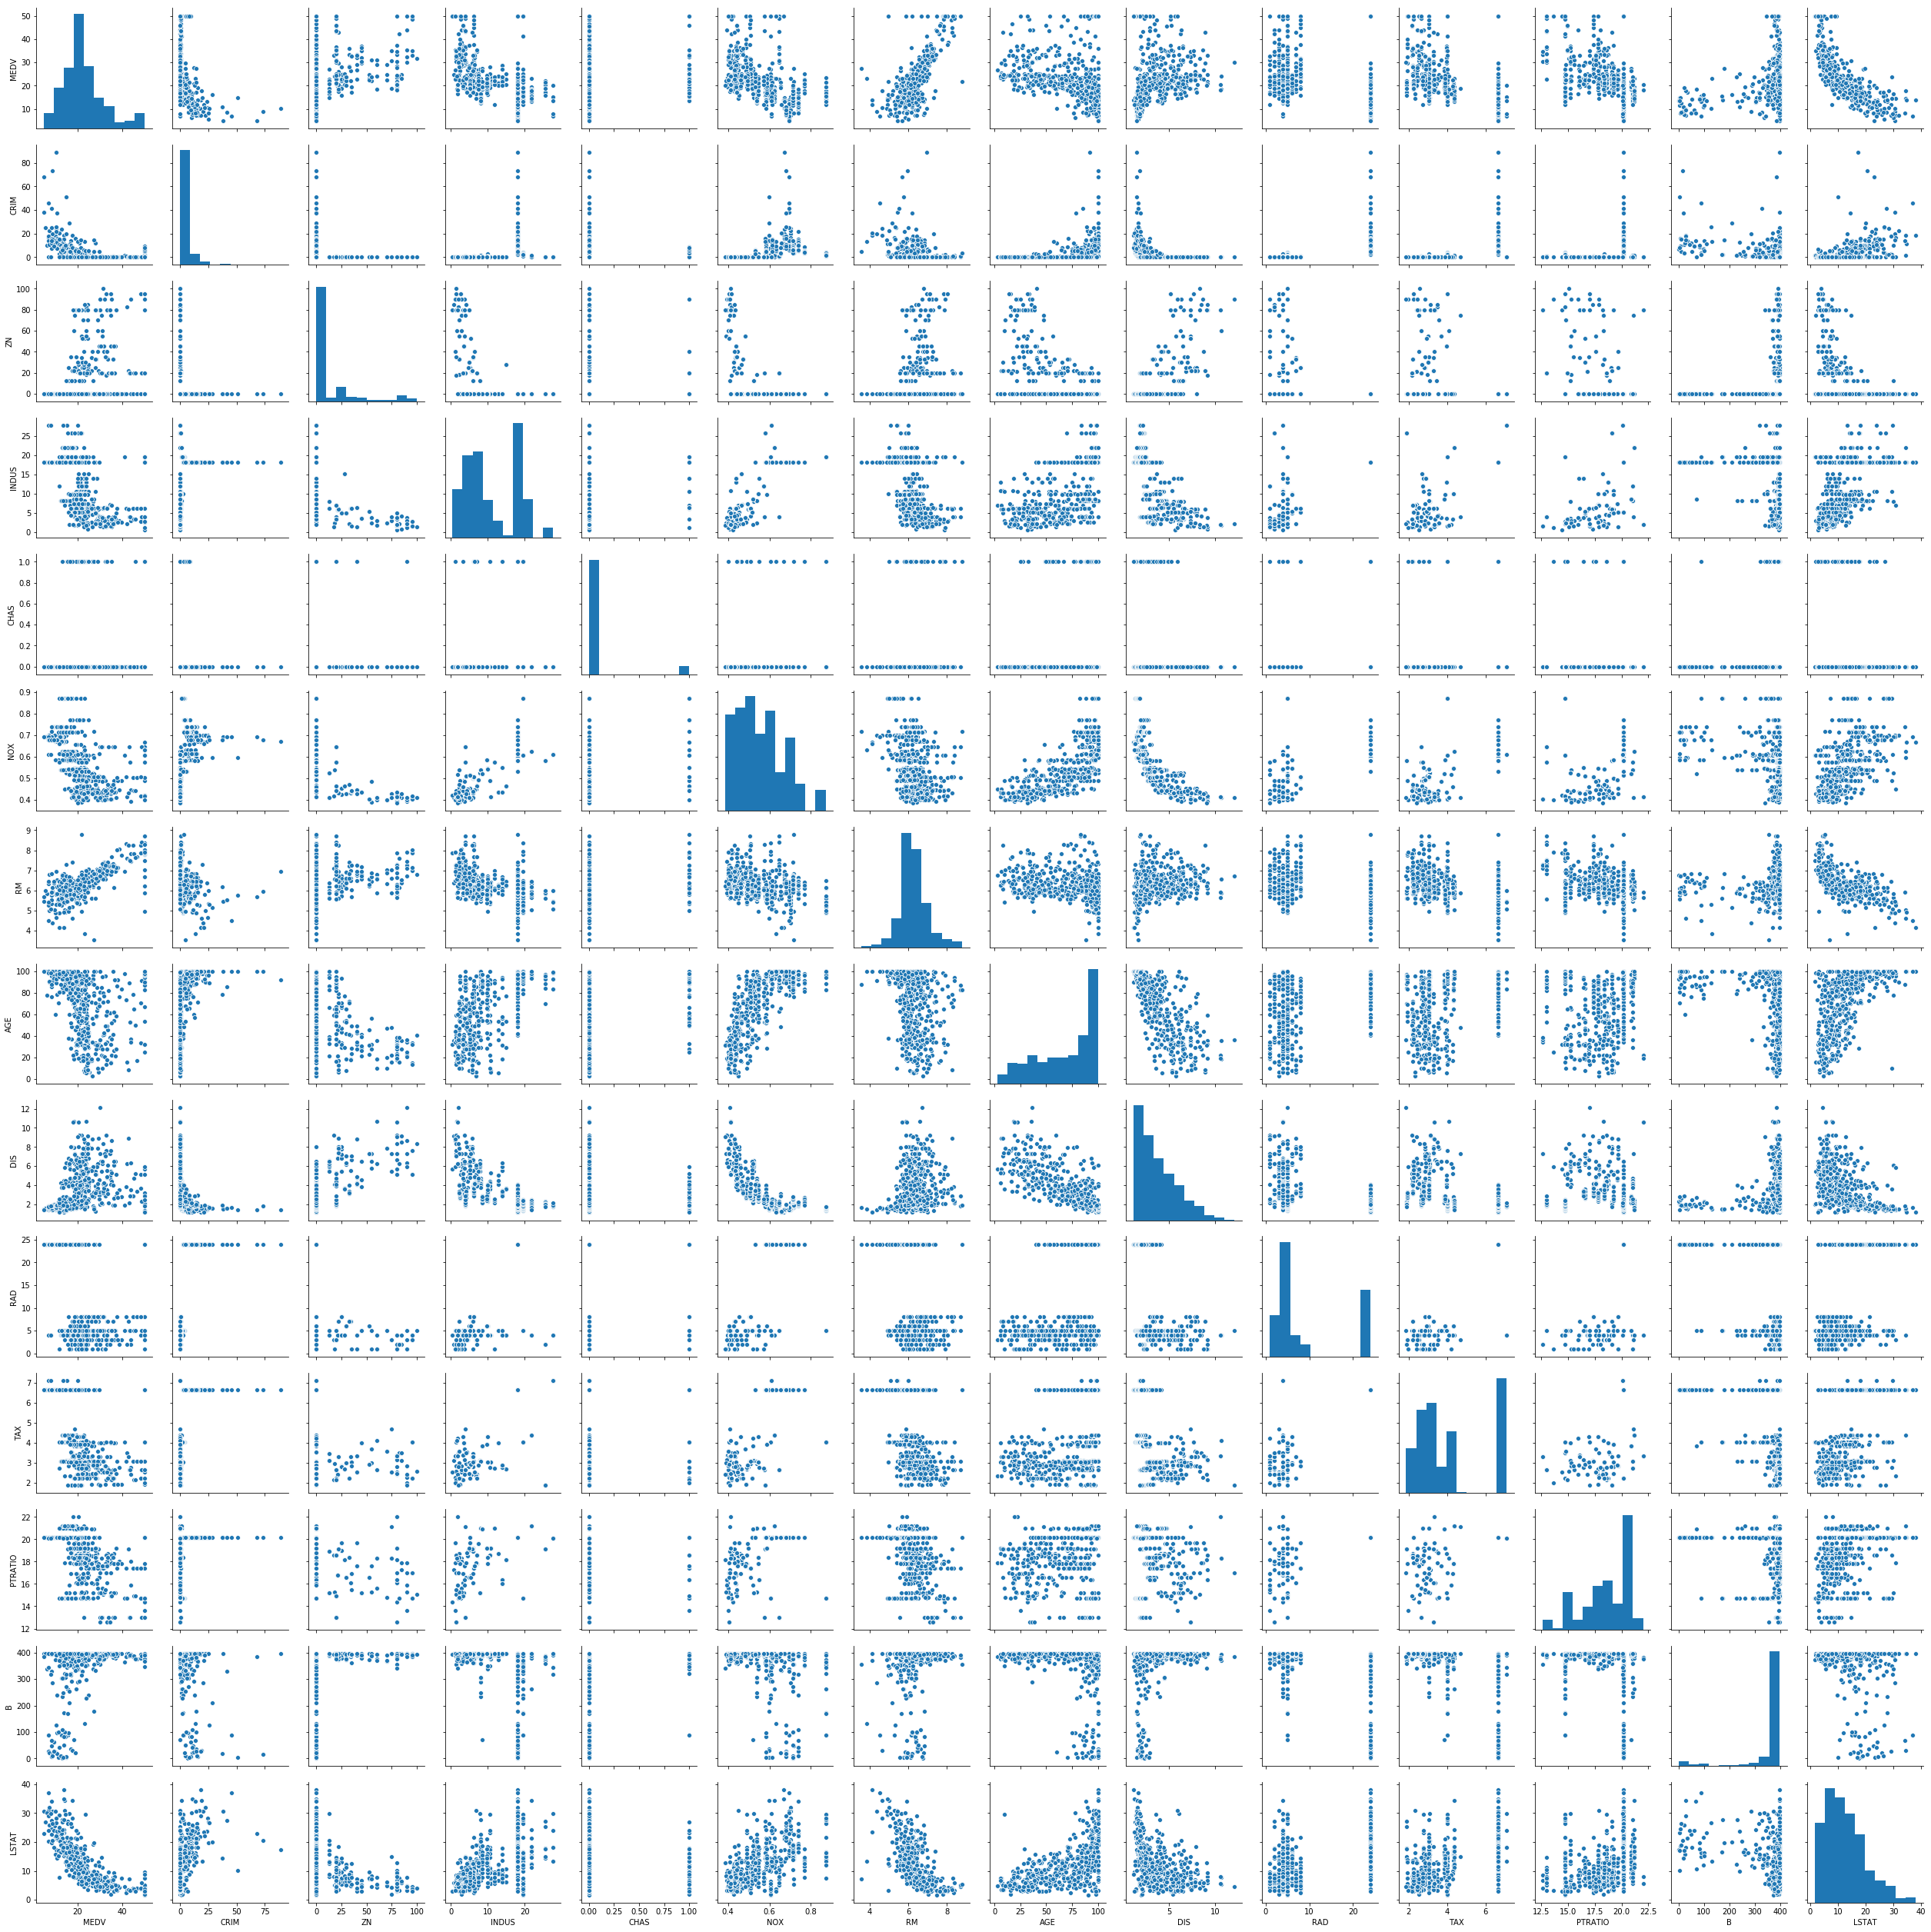

In [6]:
# Pairplot을 통해 데이터의 분포 및 대략적인 선형성을 확인
sns.pairplot(df_house)

In [7]:
# 상관계수를 통해 변수간 관계를 확인
df_house.corr().round(3)

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
MEDV,1.000,-0.388,0.360,-0.484,0.175,-0.427,0.695,-0.377,0.250,-0.382,-0.469,-0.508,0.333,-0.738
CRIM,-0.388,1.000,-0.200,0.407,-0.056,0.421,-0.219,0.353,-0.380,0.626,0.583,0.290,-0.385,0.456
ZN,0.360,-0.200,1.000,-0.534,-0.043,-0.517,0.312,-0.570,0.664,-0.312,-0.315,-0.392,0.176,-0.413
INDUS,-0.484,0.407,-0.534,1.000,0.063,0.764,-0.392,0.645,-0.708,0.595,0.721,0.383,-0.357,0.604
CHAS,0.175,-0.056,-0.043,0.063,1.000,0.091,0.091,0.087,-0.099,-0.007,-0.036,-0.122,0.049,-0.054
NOX,-0.427,0.421,-0.517,0.764,0.091,1.000,-0.302,0.731,-0.769,0.611,0.668,0.189,-0.380,0.591
RM,0.695,-0.219,0.312,-0.392,0.091,-0.302,1.000,-0.240,0.205,-0.210,-0.292,-0.356,0.128,-0.614
AGE,-0.377,0.353,-0.570,0.645,0.087,0.731,-0.240,1.000,-0.748,0.456,0.506,0.262,-0.274,0.602
DIS,0.250,-0.380,0.664,-0.708,-0.099,-0.769,0.205,-0.748,1.000,-0.495,-0.534,-0.232,0.292,-0.497
RAD,-0.382,0.626,-0.312,0.595,-0.007,0.611,-0.210,0.456,-0.495,1.000,0.910,0.465,-0.444,0.489


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faee41d8b00>,
      dtype=object)

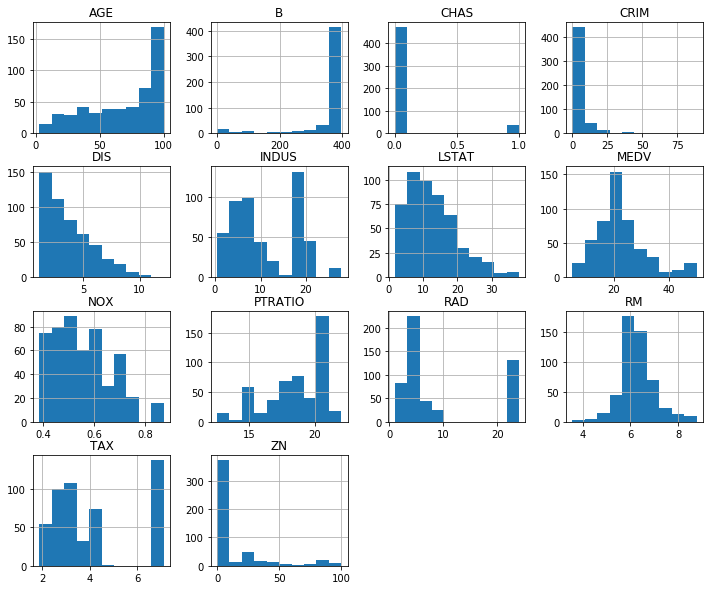

In [8]:
# histogram을 그려 각 변수의 분포를 확인.
df_house.hist(figsize = (12, 10))

1 . PairPlot - MEDV to CRIM


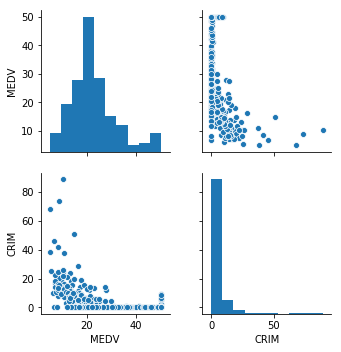


2 . PairPlot - MEDV to ZN


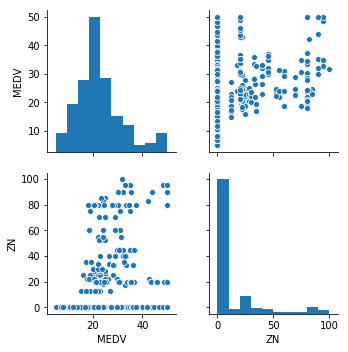


3 . PairPlot - MEDV to INDUS


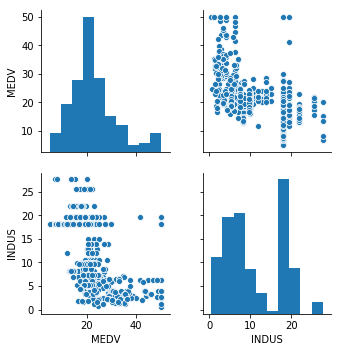


4 . PairPlot - MEDV to NOX


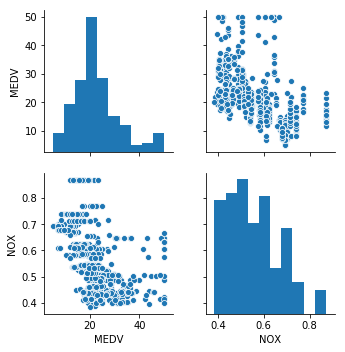


5 . PairPlot - MEDV to RM


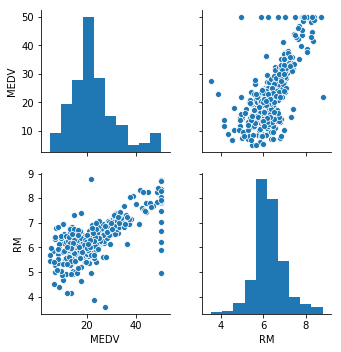


6 . PairPlot - MEDV to AGE


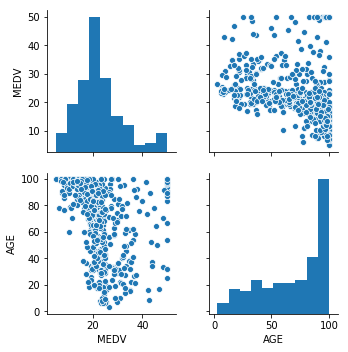


7 . PairPlot - MEDV to DIS


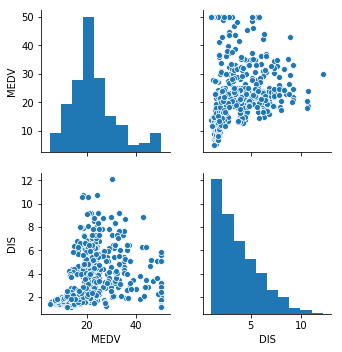


8 . PairPlot - MEDV to RAD


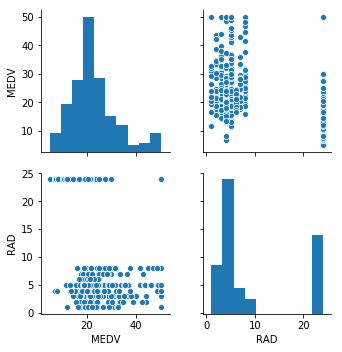


9 . PairPlot - MEDV to TAX


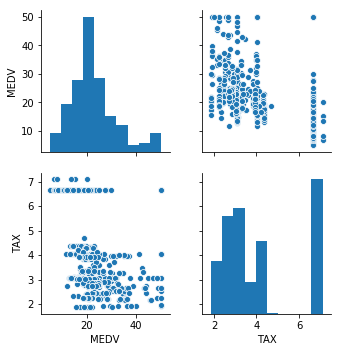


10 . PairPlot - MEDV to PTRATIO


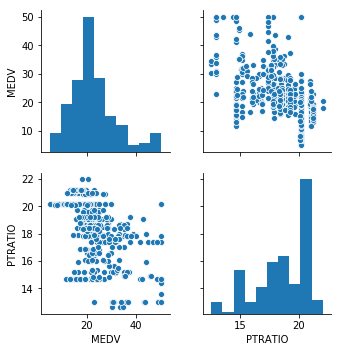


11 . PairPlot - MEDV to B


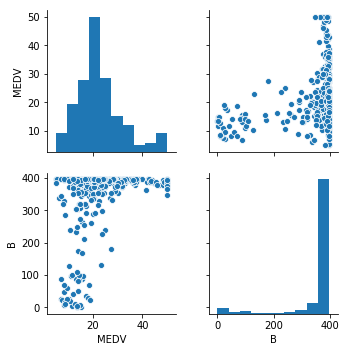


12 . PairPlot - MEDV to LSTAT


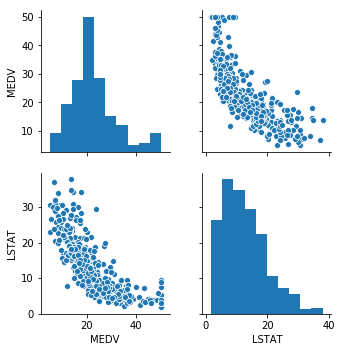

In [9]:
# 이산형 변수인 CHAS을 제외한 설명변수들에 따른 목표변수(MEDV)의 분포를 확인하자.
# Pair plot(Scatter plot and Histogram)
df_house_x_drop_CHAS = df_house_x.drop("CHAS", axis = 1, inplace = False)
k=1
for i in list(df_house_x_drop_CHAS):
    df = pd.concat([df_house[['MEDV']], df_house[[i]]], axis=1)
    print("%d . PairPlot - %s"%(k,df.columns[0]) + ' to ' + df.columns[1])
    sns.pairplot(df)
    plt.show()
    print("")
    k+=1

- CHAS : 이상현 데이터, 데이터 불균형
- RAD : 이산형 데이터, 지수가 연속적이지 않으며, 8이후엔 24만 발견됨
- INDUS : 쌍봉분포
- NOX : 높은 수치가 발견 - 이상치인지 확인 필요
- TAX : 높은 수치가 발견 - 이상치인지 확인 필요

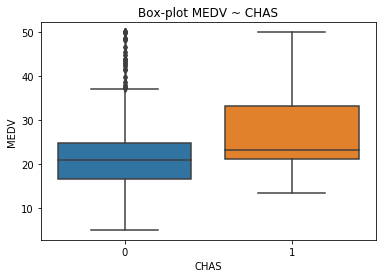

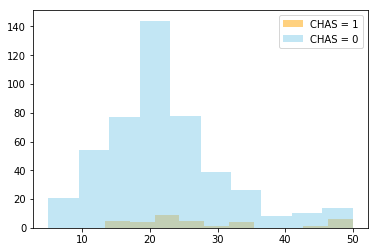

In [10]:
# CHAS

# 이산형 변수인 CHAS에 따른 목표변수(MEDV)의 분포를 확인하자.
df_MEDV_CHAS = df_house[['MEDV','CHAS']]
sns.boxplot(x='CHAS',y="MEDV", data = df_MEDV_CHAS)
plt.title("Box-plot MEDV ~ CHAS")
plt.show()

plt.hist(df_MEDV_CHAS[df_MEDV_CHAS["CHAS"] == 1]["MEDV"], label = "CHAS = 1", alpha = 0.5, color='orange')
plt.hist(df_MEDV_CHAS[df_MEDV_CHAS["CHAS"] == 0]["MEDV"], label = "CHAS = 0", alpha = 0.5, color='skyblue')
plt.legend()
# sns.pairplot(df_MEDV_CHAS, hue='CHAS')
# plt.title("Box-plot MEDV ~ CHAS")
# plt.show()
# 강 조망여부가 0일 경우 cor <0.2이며 이상치로 보이는 점들로 보아, 주택가격에 큰 영향을 주는것처럼 보이진 않는다.

In [11]:
df_MEDV_CHAS.CHAS.value_counts()

0    471
1     35
Name: CHAS, dtype: int64

- 강 조망여부가 0일 경우 cor <0.2이며 이상치로 보이는 점들로 보아, 주택가격에 큰 영향을 주는것처럼 보이진 않는다.
- 또한 조강권이 아닐 때, 상자그림에서 3사분위수 이상의 점들이 많은 것은 분포가 좌측으로 쏠려있기 때문이다.

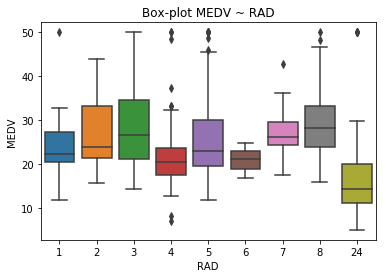

In [12]:
# RAD
df_MEDV_RAD = df_house[['MEDV','RAD']]
sns.boxplot(x='RAD',y="MEDV", data = df_MEDV_RAD)
plt.title("Box-plot MEDV ~ RAD")
plt.show()


- RAD = 24일 때, MEDV가 다른 값들에 비해 낮은 분포를 보임.

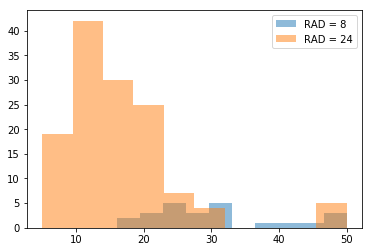

In [13]:
# 다시 확인.
plt.hist(df_MEDV_RAD[df_MEDV_RAD["RAD"] == 8]["MEDV"], label = "RAD = 8", alpha = 0.5)
plt.hist(df_MEDV_RAD[df_MEDV_RAD["RAD"] == 24]["MEDV"], label = "RAD = 24", alpha = 0.5)
plt.legend()

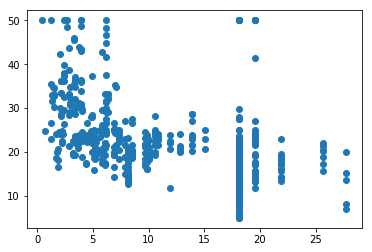

In [14]:
# INDUS
df_MEDV_INDUS = df_house[['MEDV','INDUS']]
plt.scatter(data = df_MEDV_INDUS, x = 'INDUS', y = 'MEDV')

- 연속적인 부분과 이산적인 부분이 합쳐진 분포
- 지역별 특징으로 생각된다.

In [15]:
df_house.loc[df_house.INDUS >=16 , :].head()

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
120,22.000000,0.06899,0.0,25.65,0,0.581,5.870,69.699997,2.2577,2,1.88,19.1,389.149994,14.37
121,20.299999,0.07165,0.0,25.65,0,0.581,6.004,84.099998,2.1974,2,1.88,19.1,377.670013,14.27
122,20.500000,0.09299,0.0,25.65,0,0.581,5.961,92.900002,2.0869,2,1.88,19.1,378.089996,17.93
123,17.299999,0.15038,0.0,25.65,0,0.581,5.856,97.000000,1.9444,2,1.88,19.1,370.309998,25.41
124,18.799999,0.09849,0.0,25.65,0,0.581,5.879,95.800003,2.0063,2,1.88,19.1,379.380005,17.58


In [16]:
df_house.loc[df_house.NOX >=0.8 , :]

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
142,13.400000,3.32105,0.0,19.58,1,0.871,5.403,100.000000,1.3216,5,4.03,14.7,396.899994,26.820000
143,15.600000,4.09740,0.0,19.58,0,0.871,5.468,100.000000,1.4118,5,4.03,14.7,396.899994,26.420000
144,11.800000,2.77974,0.0,19.58,0,0.871,4.903,97.800003,1.3459,5,4.03,14.7,396.899994,29.290001
145,13.800000,2.37934,0.0,19.58,0,0.871,6.130,100.000000,1.4191,5,4.03,14.7,172.910004,27.799999
146,15.600000,2.15505,0.0,19.58,0,0.871,5.628,100.000000,1.5166,5,4.03,14.7,169.270004,16.650000
147,14.600000,2.36862,0.0,19.58,0,0.871,4.926,95.699997,1.4608,5,4.03,14.7,391.709992,29.530001
148,17.799999,2.33099,0.0,19.58,0,0.871,5.186,93.800003,1.5296,5,4.03,14.7,356.989990,28.320000
149,15.400000,2.73397,0.0,19.58,0,0.871,5.597,94.900002,1.5257,5,4.03,14.7,351.850006,21.450001
150,21.500000,1.65660,0.0,19.58,0,0.871,6.122,97.300003,1.6180,5,4.03,14.7,372.799988,14.100000
151,19.600000,1.49632,0.0,19.58,0,0.871,5.404,100.000000,1.5916,5,4.03,14.7,341.600006,13.280000


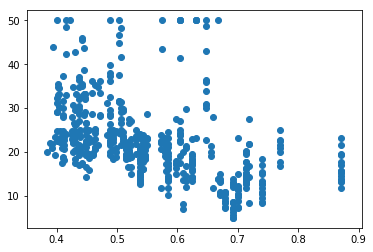

In [17]:
# NOX
df_MEDV_NOX = df_house[['MEDV','NOX']]
plt.scatter(data = df_MEDV_NOX, x = 'NOX', y = 'MEDV')

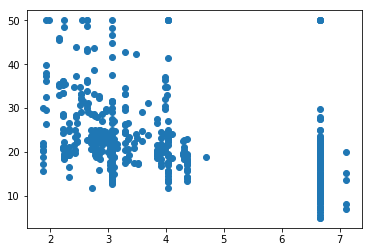

In [18]:
# TAX
df_MEDV_TAX = df_house[['MEDV','TAX']]
plt.scatter(data = df_MEDV_TAX, x = 'TAX', y = 'MEDV')

In [19]:
df_house.loc[df_house.TAX >=6 , :].head() # n =137

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
356,17.799999,8.98296,0.0,18.1,1,0.77,6.212,97.400002,2.1222,24,6.66,20.200001,377.730011,17.60
357,21.700001,3.84970,0.0,18.1,1,0.77,6.395,91.000000,2.5052,24,6.66,20.200001,391.339996,13.27
358,22.700001,5.20177,0.0,18.1,1,0.77,6.127,83.400002,2.7227,24,6.66,20.200001,395.429993,11.48
359,22.600000,4.26131,0.0,18.1,0,0.77,6.112,81.300003,2.5091,24,6.66,20.200001,390.739990,12.67
360,25.000000,4.54192,0.0,18.1,0,0.77,6.398,88.000000,2.5182,24,6.66,20.200001,374.559998,7.79


- ZN, INDUS, NOX, RAD, TAX, PTRATIO 는 지역적 특징으로 파악된다. 또한 CHAS는 추가적인 지역적 특징으로 파악된다.
- 따라서 데이터를 분할하여 분석할 필요가 있다.

## Step 2. 데이터 분석

In [20]:
# 데이터를 RAD가 1~8인 데이터와, 24인 데이터로 분할한다.
df_house_RAD24 = df_house.loc[df_house.RAD ==24 , :]
df_house_RAD1to8 = df_house.loc[df_house.RAD != 24 , :]

In [21]:
all_same_list= []
for i in list(df_house_RAD24):
    if len(df_house_RAD24[i].unique()) == 1:
        all_same_list.append(i)
        
all_same_list

['ZN', 'INDUS', 'RAD', 'TAX', 'PTRATIO']

In [22]:
# RAD24의 경우, 모든 데이터의 ['ZN', 'INDUS', 'RAD', 'TAX', 'PTRATIO']가 같기 때문에 제거한다.
df_house_RAD24_drop = df_house_RAD24
for i in range(0,len(list(all_same_list))):
    df_house_RAD24_drop = df_house_RAD24_drop.drop(list(all_same_list)[i]  , axis = 1, inplace = False)

df_house_RAD24_drop.head()

,MEDV,CRIM,CHAS,NOX,RM,AGE,DIS,B,LSTAT
356,17.799999,8.98296,1,0.77,6.212,97.400002,2.1222,377.730011,17.60
357,21.700001,3.84970,1,0.77,6.395,91.000000,2.5052,391.339996,13.27
358,22.700001,5.20177,1,0.77,6.127,83.400002,2.7227,395.429993,11.48
359,22.600000,4.26131,0,0.77,6.112,81.300003,2.5091,390.739990,12.67
360,25.000000,4.54192,0,0.77,6.398,88.000000,2.5182,374.559998,7.79


In [23]:
df_house_x_const = sm.add_constant(df_house_RAD24_drop.drop("MEDV", axis = 1, inplace = False))
df_vif = pd.DataFrame()
df_vif["variable"] = df_house_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_house_x_const.values, i) for i in range(df_house_x_const.shape[1])]

df_vif.sort_values("VIF", inplace = True)
df_vif.round(3)

,variable,VIF
7,B,1.098
3,NOX,1.279
1,CRIM,1.282
4,RM,1.297
2,CHAS,1.308
8,LSTAT,1.681
5,AGE,2.356
6,DIS,2.662
0,const,358.445


In [24]:
all_columns = " + ".join(df_house_RAD24_drop.columns[1:])
my_formula = "MEDV ~ " + all_columns

formula_model = smf.ols(formula = my_formula, data = df_house_RAD24_drop)
formula_result = formula_model.fit()
print(formula_result.summary()) 

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     33.16
Date:                Fri, 01 Feb 2019   Prob (F-statistic):           2.75e-27
Time:                        08:56:37   Log-Likelihood:                -394.03
No. Observations:                 132   AIC:                             806.1
Df Residuals:                     123   BIC:                             832.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     71.8537      8.174      8.791      0.0

In [25]:
formula_model = smf.ols(formula = "MEDV ~CRIM + CHAS + NOX + RM +DIS+LSTAT"
                        , data = df_house_RAD24_drop)
formula_result = formula_model.fit()
print(formula_result.summary()) 

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     43.96
Date:                Fri, 01 Feb 2019   Prob (F-statistic):           1.52e-28
Time:                        08:56:37   Log-Likelihood:                -395.01
No. Observations:                 132   AIC:                             804.0
Df Residuals:                     125   BIC:                             824.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     76.1121      6.990     10.888      0.0

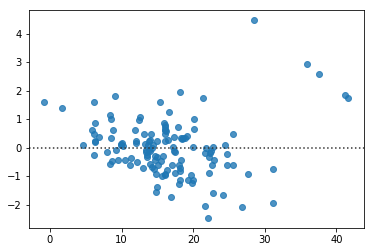

In [26]:
z = (formula_result.resid - np.mean(formula_result.resid))/np.std(formula_result.resid)
sns.residplot(formula_result.fittedvalues,z )

((array([-2.55975148, -2.2349272 , -2.04828724, -1.91383222, -1.80707022,
         -1.71764676, -1.64016531, -1.57143977, -1.50942476, -1.45272543,
         -1.40034598, -1.35154951, -1.30577464, -1.26258339, -1.2216271 ,
         -1.18262346, -1.14534048, -1.10958504, -1.0751946 , -1.04203091,
         -1.00997539, -0.97892545, -0.94879172, -0.91949583, -0.89096859,
         -0.86314863, -0.83598118, -0.80941718, -0.78341243, -0.75792699,
         -0.73292459, -0.70837218, -0.68423957, -0.66049905, -0.63712509,
         -0.61409417, -0.59138448, -0.56897579, -0.54684925, -0.52498727,
         -0.5033734 , -0.48199217, -0.46082907, -0.4398704 , -0.4191032 ,
         -0.39851522, -0.37809479, -0.35783084, -0.33771277, -0.31773049,
         -0.29787428, -0.27813484, -0.25850319, -0.23897068, -0.21952892,
         -0.2001698 , -0.18088541, -0.16166806, -0.14251024, -0.12340459,
         -0.10434388, -0.085321  , -0.06632896, -0.04736081, -0.02840969,
         -0.00946876,  0.00946876,  0.

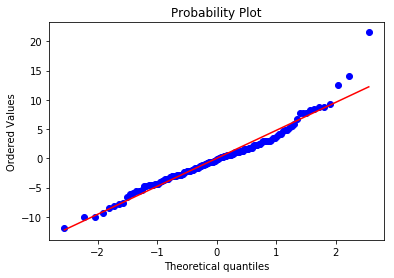

In [27]:
resid = formula_result.resid
stats.probplot(resid, plot=plt)

In [28]:
df_house_x_const = sm.add_constant(df_house_RAD1to8.drop("MEDV", axis = 1, inplace = False))
df_vif = pd.DataFrame()
df_vif["variable"] = df_house_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_house_x_const.values, i) for i in range(df_house_x_const.shape[1])]

df_vif.sort_values("VIF", inplace = True)
df_vif.round(3)

,variable,VIF
4,CHAS,1.080
9,RAD,1.187
12,B,1.394
10,TAX,1.585
11,PTRATIO,1.596
2,ZN,2.321
6,RM,2.557
3,INDUS,2.759
1,CRIM,2.773
7,AGE,2.774


In [29]:
all_columns = " + ".join(df_house_RAD1to8.columns[1:])
my_formula = "MEDV ~ " + all_columns

formula_model = smf.ols(formula = my_formula, data = df_house_RAD1to8)
formula_result = formula_model.fit()
print(formula_result.summary()) 

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     180.3
Date:                Fri, 01 Feb 2019   Prob (F-statistic):          1.05e-148
Time:                        08:56:38   Log-Likelihood:                -950.04
No. Observations:                 374   AIC:                             1928.
Df Residuals:                     360   BIC:                             1983.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -15.3397      4.709     -3.257      0.0

In [30]:
formula_model = smf.ols(formula = "MEDV ~CRIM +  NOX + RM+AGE +DIS+RAD+TAX+PTRATIO+B+LSTAT", data = df_house_RAD1to8)
formula_result = formula_model.fit()
print(formula_result.summary()) 

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     231.8
Date:                Fri, 01 Feb 2019   Prob (F-statistic):          6.59e-151
Time:                        08:56:38   Log-Likelihood:                -953.19
No. Observations:                 374   AIC:                             1928.
Df Residuals:                     363   BIC:                             1972.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -15.3191      4.718     -3.247      0.0

In [31]:
formula_model = smf.ols(formula = "MEDV ~CRIM +  NOX + RM+AGE +DIS+TAX+PTRATIO++B+LSTAT", data = df_house_RAD1to8)
formula_result = formula_model.fit()
print(formula_result.summary()) 

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     256.0
Date:                Fri, 01 Feb 2019   Prob (F-statistic):          1.57e-151
Time:                        08:56:38   Log-Likelihood:                -954.61
No. Observations:                 374   AIC:                             1929.
Df Residuals:                     364   BIC:                             1968.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -15.3018      4.730     -3.235      0.0

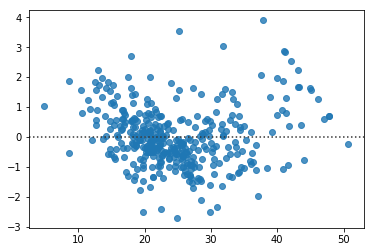

In [32]:
z = (formula_result.resid - np.mean(formula_result.resid))/np.std(formula_result.resid)
sns.residplot(formula_result.fittedvalues,z)

((array([-2.90239298, -2.61248917, -2.4488595 , -2.33252073, -2.2411603 ,
         -2.16538684, -2.10032282, -2.04309704, -1.99187101, -1.94539387,
         -1.90277453, -1.86335489, -1.82663457, -1.79222388, -1.75981316,
         -1.72915213, -1.70003549, -1.67229264, -1.64578025, -1.62037666,
         -1.59597771, -1.57249348, -1.54984581, -1.52796629, -1.5067947 ,
         -1.48627775, -1.46636804, -1.44702319, -1.42820519, -1.40987977,
         -1.39201595, -1.37458563, -1.3575632 , -1.3409253 , -1.32465054,
         -1.30871926, -1.29311339, -1.27781624, -1.26281241, -1.24808758,
         -1.23362851, -1.21942284, -1.20545908, -1.1917265 , -1.17821505,
         -1.16491534, -1.15181855, -1.1389164 , -1.12620111, -1.11366534,
         -1.10130218, -1.0891051 , -1.07706792, -1.06518482, -1.05345026,
         -1.04185899, -1.03040604, -1.01908667, -1.0078964 , -0.99683093,
         -0.9858862 , -0.9750583 , -0.96434354, -0.95373836, -0.94323937,
         -0.93284334, -0.92254717, -0.

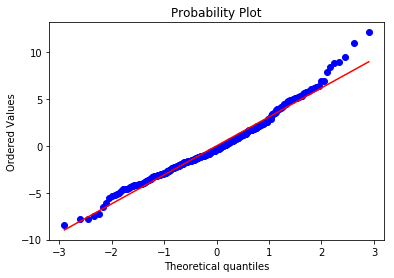

In [33]:
resid = formula_result.resid
stats.probplot(resid, plot=plt)